# Chapter 6 - Apply models to idiopathic participants

## Setup

Run Python file to import libraries and custom functions

In [1]:
%run libraries.py

/Users/joefarrington/anaconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/joefarrington/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Set paths for data and models

In [2]:
data_path = '/Users/joefarrington/Documents/MSc Machine Learning/Project/August/Data for import/'
results_path = '/Users/joefarrington/Documents/MSc Machine Learning/Project/August/Results/Ch6idiosubset/'

Define a string to be added to the name of all saved results from this notebook

In [3]:
nbname = 'Ch6idiosubset'

Import the data for the Bruining dataset

In [4]:
X_syn_B = pd.read_csv(data_path+'X_all_B.csv', index_col=0)
y_syn_B = np.array(pd.read_csv(data_path+'y_all_B.csv', index_col=0, header=None)).reshape(-1,)

Import the data for all the syndromic participants

In [5]:
X_syn_all = pd.read_csv(data_path+'X_all_Rev.csv', index_col=0)
y_syn_all = np.array(pd.read_csv(data_path+'y_all_Rev.csv', index_col=0, header=None)).reshape(-1,)

Import the data for the participants with idiopathic ASD

In [6]:
X_idio_subset = pd.read_csv(data_path+'X_idio_subset.csv', index_col=0)

Define an sklearn scorer object to calculate the Matthews Correlation Coefficient (MCC)

In [7]:
mcc_scorer = make_scorer(matthews_corrcoef)

Function to train models on syndromic and predict on idiopathic

In [8]:
def train_syn_pred_idio(X_B, y_B, X_Rev, y_Rev, X_idio, n_folds, param_grid, model, scorer, verbose):
    
    #For Bruining
    skf_B = StratifiedKFold(n_splits=n_folds)
    gs_B = GridSearchCV(model, param_grid, cv=skf_B, iid=False, scoring=scorer, n_jobs=-1, verbose=verbose)
    gs_B.fit(X_B, y_B)
    ypreds_B = gs_B.predict(X_idio)
    
    #For whole syndromic dataset
    skf_Rev = StratifiedKFold(n_splits=n_folds)
    gs_Rev = GridSearchCV(model, param_grid, cv=skf_Rev, iid=False, scoring=scorer, n_jobs=-1, verbose=verbose)
    gs_Rev.fit(X_Rev, y_Rev)
    ypreds_Rev = gs_Rev.predict(X_idio)
    
    #Produce dataframe that compares predictions
    
    
    B_labels = np.unique(y_B)
    nclasses_B = len(B_labels)
    
    Rev_labels = np.unique(y_Rev)
    nclasses_Rev = len(Rev_labels)

    res_df = pd.DataFrame(np.zeros((nclasses_B, nclasses_Rev)), index = B_labels, columns = Rev_labels)
    
    for i in range(0, len(ypreds_Rev)):
        r = ypreds_B[i]
        c = ypreds_Rev[i]
        res_df.loc[r,c] += 1
    
    #Return a dictionary with the results
    res_dict = {'model_B': gs_B, 'model_Rev': gs_Rev, 'ypreds_B':ypreds_B, 'ypreds_Rev':ypreds_Rev, 'res_df':res_df}
    
    print(res_df)
    
    return res_dict
    

## Model 1: OvO SVM with RBF kernel

Define the number of folds for cross-validation

In [9]:
n_folds = 10

Define the model

In [10]:
svc_rbf = SVC(decision_function_shape='ovo', kernel='rbf')
steps_rbf = [('scaler', StandardScaler()),
     ('model',svc_rbf)]
pipeline_rbf = Pipeline(steps_rbf)

Define the parameters for the grid seach

In [11]:
rbf_C_range = np.logspace(start=-5, stop=15, num=21, base=2)
rbf_gamma_range = np.logspace(start=-15, stop=3, num=19, base=2)
rbf_parameters = dict(model__gamma=rbf_gamma_range, model__C=rbf_C_range)

Run the training and prediction

In [12]:
rbf_svm_resdict = train_syn_pred_idio(X_B = X_syn_B, y_B = y_syn_B, X_Rev = X_syn_all, y_Rev = y_syn_all, 
                                           X_idio = X_idio_subset, n_folds = n_folds, param_grid = rbf_parameters,
                                           model = pipeline_rbf, scorer = mcc_scorer, verbose =1)

Fitting 10 folds for each of 399 candidates, totalling 3990 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1812 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 3990 out of 3990 | elapsed:   14.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 399 candidates, totalling 3990 fits


[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1360 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 3360 tasks      | elapsed:   29.7s


         22q11DS  Down  FXS-F  FXS-M  NF1  PW-UPD  PW-del  SMC15   TSC  XXY
22q11DS      2.0   0.0    2.0    8.0  2.0     0.0     0.0    0.0  11.0  1.0
Down         0.0   0.0    0.0    0.0  0.0     0.0     0.0    0.0   0.0  0.0
PW           0.0   0.0    0.0    1.0  0.0     1.0     0.0    0.0   2.0  0.0
SMC15        0.0   0.0    0.0    1.0  0.0     0.0     0.0    0.0   0.0  0.0
TSC          0.0   0.0    2.0   16.0  7.0     0.0     0.0    0.0  40.0  0.0
XXY          0.0   0.0    0.0    5.0  3.0     0.0     0.0    0.0  18.0  2.0


[Parallel(n_jobs=-1)]: Done 3990 out of 3990 | elapsed:   37.9s finished


Save the results

In [13]:
pickle.dump(rbf_svm_resdict, open(results_path+f"rbf_svm_resdict.p", "wb" ))

Load the results

In [14]:
rbf_svm_dict = pickle.load(open(results_path+f"rbf_svm_resdict.p", "rb" ))

Print the dataframe (normalized)

In [18]:
rbf_svm_dict['res_df']/124

,22q11DS,Down,FXS-F,FXS-M,NF1,PW-UPD,PW-del,SMC15,TSC,XXY
22q11DS,0.016129,0.0,0.016129,0.064516,0.016129,0.000000,0.0,0.0,0.088710,0.008065
Down,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
PW,0.000000,0.0,0.000000,0.008065,0.000000,0.008065,0.0,0.0,0.016129,0.000000
SMC15,0.000000,0.0,0.000000,0.008065,0.000000,0.000000,0.0,0.0,0.000000,0.000000
TSC,0.000000,0.0,0.016129,0.129032,0.056452,0.000000,0.0,0.0,0.322581,0.000000
XXY,0.000000,0.0,0.000000,0.040323,0.024194,0.000000,0.0,0.0,0.145161,0.016129


Print the proportions assigned to each class

In [19]:
pd.Series(rbf_svm_resdict['ypreds_B']).value_counts()/124

TSC        0.524194
XXY        0.225806
22q11DS    0.209677
PW         0.032258
SMC15      0.008065
dtype: float64

In [20]:
pd.Series(rbf_svm_resdict['ypreds_Rev']).value_counts()/124

TSC        0.572581
FXS-M      0.250000
NF1        0.096774
FXS-F      0.032258
XXY        0.024194
22q11DS    0.016129
PW-UPD     0.008065
dtype: float64

Plot a figure for the results

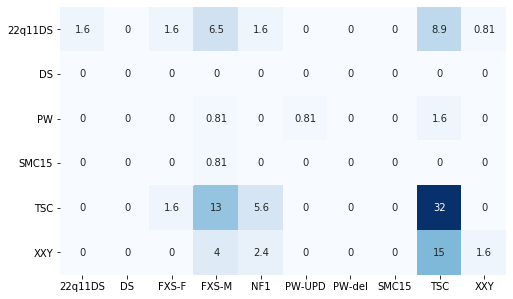

In [21]:
fig, ax = plt.subplots(figsize=(8,16))
sns.heatmap((rbf_svm_resdict['res_df']), cmap='Blues', annot = (rbf_svm_resdict['res_df'])/1.24, 
            square=True, cbar=False, ax=ax);

B_labels = np.unique(y_syn_B);
B_labels[1] = 'DS';

Rev_labels = np.unique(y_syn_all);
Rev_labels[1] = 'DS';

ax.set_xticklabels(Rev_labels);
ax.set_yticklabels(B_labels);

## Model 2: OvO SVM with linear kernel

Define the number of folds for cross-validation

In [22]:
n_folds = 10

Define the model

In [23]:
svc_lin = SVC(decision_function_shape='ovo', kernel='linear')
steps_lin = [('scaler', StandardScaler()),
     ('model',svc_lin)]
pipeline_lin = Pipeline(steps_lin)

Define the parameters for the grid seach

In [24]:
lin_C_range = np.logspace(start=-10, stop=10, num=21, base=2)
lin_parameters = dict(model__C=lin_C_range)

Run the training and prediction

In [25]:
lin_svm_resdict = train_syn_pred_idio(X_B = X_syn_B, y_B = y_syn_B, X_Rev = X_syn_all, y_Rev = y_syn_all, 
                                           X_idio = X_idio_subset, n_folds = n_folds, param_grid = lin_parameters,
                                           model = pipeline_lin, scorer = mcc_scorer, verbose =1)

Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    5.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    1.7s


         22q11DS  Down  FXS-F  FXS-M  NF1  PW-UPD  PW-del  SMC15   TSC  XXY
22q11DS      3.0   0.0    1.0    8.0  1.0     0.0     0.0    0.0   7.0  0.0
Down         0.0   0.0    0.0    0.0  0.0     0.0     0.0    0.0   0.0  0.0
PW           0.0   0.0    0.0    0.0  0.0     2.0     0.0    0.0   2.0  0.0
SMC15        0.0   0.0    0.0    2.0  2.0     0.0     0.0    1.0   3.0  0.0
TSC          0.0   0.0    1.0   13.0  3.0     0.0     0.0    1.0  46.0  0.0
XXY          0.0   0.0    2.0    2.0  6.0     0.0     0.0    0.0  15.0  3.0


[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:  2.6min finished


Save the results

In [32]:
pickle.dump(lin_svm_resdict, open(results_path+f"lin_svm_resdict.p", "wb" ))

Load the results

In [33]:
lin_svm_dict = pickle.load(open(results_path+f"lin_svm_resdict.p", "rb" ))

Print the dataframe (normalized)

In [34]:
lin_svm_dict['res_df']/124

,22q11DS,Down,FXS-F,FXS-M,NF1,PW-UPD,PW-del,SMC15,TSC,XXY
22q11DS,0.024194,0.0,0.008065,0.064516,0.008065,0.000000,0.0,0.000000,0.056452,0.000000
Down,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
PW,0.000000,0.0,0.000000,0.000000,0.000000,0.016129,0.0,0.000000,0.016129,0.000000
SMC15,0.000000,0.0,0.000000,0.016129,0.016129,0.000000,0.0,0.008065,0.024194,0.000000
TSC,0.000000,0.0,0.008065,0.104839,0.024194,0.000000,0.0,0.008065,0.370968,0.000000
XXY,0.000000,0.0,0.016129,0.016129,0.048387,0.000000,0.0,0.000000,0.120968,0.024194


Print the proportions assigned to each class

In [35]:
pd.Series(lin_svm_resdict['ypreds_B']).value_counts()/124

TSC        0.516129
XXY        0.225806
22q11DS    0.161290
SMC15      0.064516
PW         0.032258
dtype: float64

In [36]:
pd.Series(lin_svm_resdict['ypreds_Rev']).value_counts()/124

TSC        0.588710
FXS-M      0.201613
NF1        0.096774
FXS-F      0.032258
22q11DS    0.024194
XXY        0.024194
PW-UPD     0.016129
SMC15      0.016129
dtype: float64

Plot a figure for the results

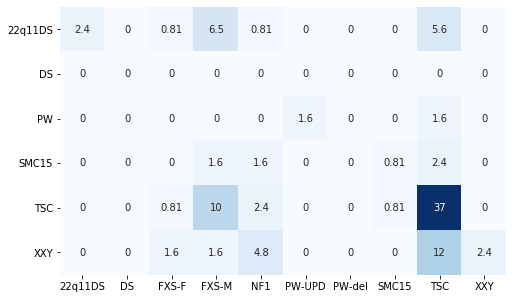

In [37]:
fig, ax = plt.subplots(figsize=(8,16))
sns.heatmap((lin_svm_resdict['res_df']), cmap='Blues', annot = (lin_svm_resdict['res_df'])/1.24, 
            square=True, cbar=False, ax=ax);

B_labels = np.unique(y_syn_B);
B_labels[1] = 'DS';

Rev_labels = np.unique(y_syn_all);
Rev_labels[1] = 'DS';

ax.set_xticklabels(Rev_labels);
ax.set_yticklabels(B_labels);

## Model 3: Naive Bayes (learn prior)

See <b>Naive Bayes in R.ipynb</b>

Load in the results

In [76]:
nb_noprior_res = pd.read_csv(results_path+'nb_idio_noprior_res.csv', index_col=0)

Print the proportions assigned to each class

In [79]:
nb_noprior_res['ypreds_B'].value_counts()/124

SMC15      0.516129
TSC        0.330645
XXY        0.088710
22q11DS    0.056452
PW         0.008065
Name: ypreds_B, dtype: float64

In [80]:
nb_noprior_res['ypreds_Rev'].value_counts()/124

FXS-M      0.556452
TSC        0.145161
SMC15      0.145161
NF1        0.104839
XXY        0.024194
FXS-F      0.016129
22q11DS    0.008065
Name: ypreds_Rev, dtype: float64

Produce a dataframe comparing the predictions

In [81]:
B_labels = np.unique(y_syn_B)
nclasses_B = len(B_labels)

Rev_labels = np.unique(y_syn_all)
nclasses_Rev = len(Rev_labels)

In [82]:
nb_noprior_res_df = pd.DataFrame(np.zeros((nclasses_B, nclasses_Rev)), index = B_labels, columns = Rev_labels)

In [83]:
ypreds_B = np.array(nb_noprior_res['ypreds_B'])
ypreds_Rev = np.array(nb_noprior_res['ypreds_Rev'])

for i in range(0, len(ypreds_Rev)):
    r = ypreds_B[i]
    c = ypreds_Rev[i]
    nb_noprior_res_df.loc[r,c] += 1

Print the dataframe (normalized)

In [85]:
nb_noprior_res_df/124

,22q11DS,Down,FXS-F,FXS-M,NF1,PW-UPD,PW-del,SMC15,TSC,XXY
22q11DS,0.008065,0.0,0.000000,0.024194,0.008065,0.0,0.0,0.000000,0.016129,0.000000
Down,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
PW,0.000000,0.0,0.008065,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
SMC15,0.000000,0.0,0.000000,0.322581,0.048387,0.0,0.0,0.145161,0.000000,0.000000
TSC,0.000000,0.0,0.000000,0.177419,0.032258,0.0,0.0,0.000000,0.120968,0.000000
XXY,0.000000,0.0,0.008065,0.032258,0.016129,0.0,0.0,0.000000,0.008065,0.024194


Plot a figure with the results

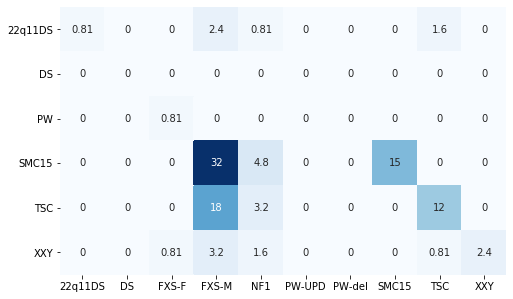

In [86]:
fig, ax = plt.subplots(figsize=(8,16))
sns.heatmap(nb_noprior_res_df, cmap='Blues', annot = nb_noprior_res_df/1.24, 
            square=True, cbar=False, ax=ax);

B_labels = np.unique(y_syn_B);
B_labels[1] = 'DS';

Rev_labels = np.unique(y_syn_all);
Rev_labels[1] = 'DS';

ax.set_xticklabels(Rev_labels);
ax.set_yticklabels(B_labels);

## Model 4: Naive Bayes (uniform prior)

See <b>Naive Bayes in R.ipynb</b>

Load in the results

In [87]:
nb_uniprior_res = pd.read_csv(results_path+'nb_idio_uniprior_res.csv', index_col=0)

Print the proportions assigned to each class

In [88]:
nb_uniprior_res['ypreds_B'].value_counts()/124

SMC15      0.556452
TSC        0.314516
XXY        0.080645
22q11DS    0.032258
Down       0.016129
Name: ypreds_B, dtype: float64

In [89]:
nb_uniprior_res['ypreds_Rev'].value_counts()/124

FXS-M      0.459677
NF1        0.233871
SMC15      0.193548
TSC        0.064516
XXY        0.024194
FXS-F      0.016129
22q11DS    0.008065
Name: ypreds_Rev, dtype: float64

Produce a dataframe comparing the predictions

In [90]:
B_labels = np.unique(y_syn_B)
nclasses_B = len(B_labels)

Rev_labels = np.unique(y_syn_all)
nclasses_Rev = len(Rev_labels)

In [91]:
nb_uniprior_res_df = pd.DataFrame(np.zeros((nclasses_B, nclasses_Rev)), index = B_labels, columns = Rev_labels)

In [92]:
ypreds_B = np.array(nb_uniprior_res['ypreds_B'])
ypreds_Rev = np.array(nb_uniprior_res['ypreds_Rev'])

for i in range(0, len(ypreds_Rev)):
    r = ypreds_B[i]
    c = ypreds_Rev[i]
    nb_uniprior_res_df.loc[r,c] += 1

Print the dataframe (normalized)

In [93]:
nb_uniprior_res_df/124

,22q11DS,Down,FXS-F,FXS-M,NF1,PW-UPD,PW-del,SMC15,TSC,XXY
22q11DS,0.008065,0.0,0.000000,0.016129,0.008065,0.0,0.0,0.000000,0.000000,0.000000
Down,0.000000,0.0,0.016129,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
PW,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
SMC15,0.000000,0.0,0.000000,0.282258,0.080645,0.0,0.0,0.193548,0.000000,0.000000
TSC,0.000000,0.0,0.000000,0.137097,0.129032,0.0,0.0,0.000000,0.048387,0.000000
XXY,0.000000,0.0,0.000000,0.024194,0.016129,0.0,0.0,0.000000,0.016129,0.024194


Plot a figure with the results

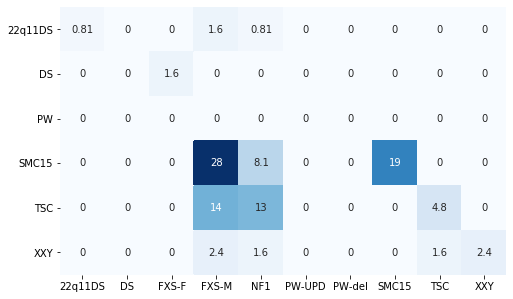

In [94]:
fig, ax = plt.subplots(figsize=(8,16))
sns.heatmap(nb_uniprior_res_df, cmap='Blues', annot = nb_uniprior_res_df/1.24, 
            square=True, cbar=False, ax=ax);

B_labels = np.unique(y_syn_B);
B_labels[1] = 'DS';

Rev_labels = np.unique(y_syn_all);
Rev_labels[1] = 'DS';

ax.set_xticklabels(Rev_labels);
ax.set_yticklabels(B_labels);

## Model 5 : Standard Random Forest

Define the number of folds for cross-validation

In [38]:
n_folds = 10

Define the model

In [39]:
rfc_naive = RandomForestClassifier()

Define the parameters for the grid seach

In [40]:
n_features = X_syn_B.shape[1]
default_mtry = np.sqrt(n_features)
rfc_parameters = {'max_features': [int(0.5*default_mtry), int(default_mtry), int(1.5*default_mtry), int(2*default_mtry), int(3*default_mtry)],
             'n_estimators': [2000], 'min_samples_leaf': [1,2, 3, 4, 5]}

Run the training and prediction

In [41]:
rfc_naive_resdict = train_syn_pred_idio(X_B = X_syn_B, y_B = y_syn_B, X_Rev = X_syn_all, y_Rev = y_syn_all, 
                                           X_idio = X_idio_subset, n_folds = n_folds, param_grid = rfc_parameters,
                                           model = rfc_naive, scorer = mcc_scorer, verbose =1)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.5s
/Users/joefarrington/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  2.0min finished


Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/joefarrington/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  2.6min finished


         22q11DS  Down  FXS-F  FXS-M  NF1  PW-UPD  PW-del  SMC15   TSC  XXY
22q11DS      1.0   0.0    0.0   11.0  0.0     0.0     0.0    1.0  20.0  0.0
Down         0.0   0.0    0.0    0.0  0.0     0.0     0.0    0.0   0.0  0.0
PW           0.0   0.0    1.0    2.0  0.0     0.0     0.0    0.0   2.0  0.0
SMC15        0.0   0.0    0.0    1.0  0.0     0.0     0.0    0.0   0.0  0.0
TSC          0.0   0.0    0.0   19.0  3.0     0.0     0.0    2.0  46.0  0.0
XXY          0.0   0.0    0.0    2.0  0.0     0.0     0.0    0.0  12.0  1.0


Save the results

In [43]:
pickle.dump(rfc_naive_resdict, open(results_path+f"rfc_naive_resdict.p", "wb" ))

Load the results

In [44]:
rfc_naive_resdict = pickle.load(open(results_path+f"rfc_naive_resdict.p", "rb" ))

Print the dataframe (normalized)

In [45]:
rfc_naive_resdict['res_df']/124

,22q11DS,Down,FXS-F,FXS-M,NF1,PW-UPD,PW-del,SMC15,TSC,XXY
22q11DS,0.008065,0.0,0.000000,0.088710,0.000000,0.0,0.0,0.008065,0.161290,0.000000
Down,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
PW,0.000000,0.0,0.008065,0.016129,0.000000,0.0,0.0,0.000000,0.016129,0.000000
SMC15,0.000000,0.0,0.000000,0.008065,0.000000,0.0,0.0,0.000000,0.000000,0.000000
TSC,0.000000,0.0,0.000000,0.153226,0.024194,0.0,0.0,0.016129,0.370968,0.000000
XXY,0.000000,0.0,0.000000,0.016129,0.000000,0.0,0.0,0.000000,0.096774,0.008065


Print the proportions assigned to each class

In [46]:
pd.Series(rfc_naive_resdict['ypreds_B']).value_counts()/1.24

TSC        56.451613
22q11DS    26.612903
XXY        12.096774
PW          4.032258
SMC15       0.806452
dtype: float64

In [47]:
pd.Series(rfc_naive_resdict['ypreds_Rev']).value_counts()/1.24

TSC        64.516129
FXS-M      28.225806
NF1         2.419355
SMC15       2.419355
XXY         0.806452
22q11DS     0.806452
FXS-F       0.806452
dtype: float64

Plot a figure for the results

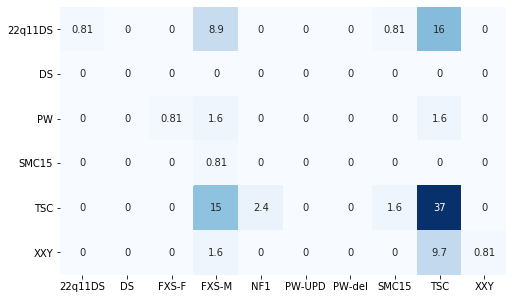

In [49]:
fig, ax = plt.subplots(figsize=(8,16))
sns.heatmap((rfc_naive_resdict['res_df']), cmap='Blues', annot = (rfc_naive_resdict['res_df'])/1.24, 
            square=True, cbar=False, ax=ax);

B_labels = np.unique(y_syn_B);
B_labels[1] = 'DS';

Rev_labels = np.unique(y_syn_all);
Rev_labels[1] = 'DS';

ax.set_xticklabels(Rev_labels);
ax.set_yticklabels(B_labels);

## Model 6 : Balanced Random Forest

Define the number of folds for cross-validation

In [50]:
n_folds = 10

Define the model

In [51]:
rfc_bal = BalancedRandomForestClassifier()

Define the parameters for the grid seach

In [52]:
n_features = X_syn_B.shape[1]
default_mtry = np.sqrt(n_features)
rfc_parameters = {'max_features': [int(0.5*default_mtry), int(default_mtry), int(1.5*default_mtry), int(2*default_mtry), int(3*default_mtry)],
             'n_estimators': [2000], 'min_samples_leaf': [1,2, 3, 4, 5]}

Run the training and prediction

In [53]:
rfc_bal_resdict = train_syn_pred_idio(X_B = X_syn_B, y_B = y_syn_B, X_Rev = X_syn_all, y_Rev = y_syn_all, 
                                           X_idio = X_idio_subset, n_folds = n_folds, param_grid = rfc_parameters,
                                           model = rfc_bal, scorer = mcc_scorer, verbose =1)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  4.8min finished


Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/joefarrington/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   56.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  6.2min finished


         22q11DS  Down  FXS-F  FXS-M   NF1  PW-UPD  PW-del  SMC15   TSC  XXY
22q11DS      2.0   0.0    0.0    3.0   2.0     0.0     0.0    0.0   1.0  0.0
Down         0.0   0.0    2.0    1.0   2.0     0.0     0.0    0.0   0.0  0.0
PW           0.0   0.0    0.0    0.0   0.0     0.0     0.0    0.0   0.0  0.0
SMC15        0.0   0.0    0.0    7.0   6.0     0.0     0.0    6.0   2.0  0.0
TSC          0.0   0.0    2.0   31.0  26.0     0.0     0.0    8.0  12.0  0.0
XXY          0.0   0.0    1.0    3.0   4.0     0.0     0.0    0.0   1.0  2.0


Save the results

In [60]:
pickle.dump(rfc_bal_resdict, open(results_path+f"rfc_bal_resdict.p", "wb" ))

Load the results

In [61]:
rfc_bal_resdict = pickle.load(open(results_path+f"rfc_bal_resdict.p", "rb" ))

Print the dataframe (normalized)

In [62]:
rfc_bal_resdict['res_df']/124

,22q11DS,Down,FXS-F,FXS-M,NF1,PW-UPD,PW-del,SMC15,TSC,XXY
22q11DS,0.016129,0.0,0.000000,0.024194,0.016129,0.0,0.0,0.000000,0.008065,0.000000
Down,0.000000,0.0,0.016129,0.008065,0.016129,0.0,0.0,0.000000,0.000000,0.000000
PW,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
SMC15,0.000000,0.0,0.000000,0.056452,0.048387,0.0,0.0,0.048387,0.016129,0.000000
TSC,0.000000,0.0,0.016129,0.250000,0.209677,0.0,0.0,0.064516,0.096774,0.000000
XXY,0.000000,0.0,0.008065,0.024194,0.032258,0.0,0.0,0.000000,0.008065,0.016129


Print the proportions assigned to each class

In [63]:
pd.Series(rfc_bal_resdict['ypreds_B']).value_counts()/124

TSC        0.637097
SMC15      0.169355
XXY        0.088710
22q11DS    0.064516
Down       0.040323
dtype: float64

In [64]:
pd.Series(rfc_bal_resdict['ypreds_Rev']).value_counts()/124

FXS-M      0.362903
NF1        0.322581
TSC        0.129032
SMC15      0.112903
FXS-F      0.040323
22q11DS    0.016129
XXY        0.016129
dtype: float64

Plot a figure for the results

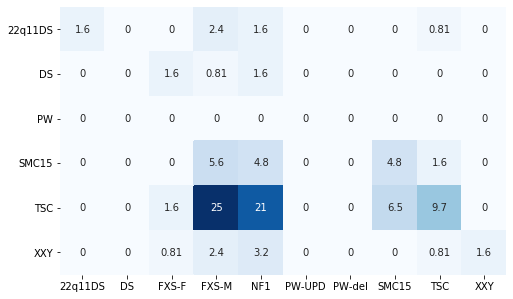

In [65]:
fig, ax = plt.subplots(figsize=(8,16))
sns.heatmap((rfc_bal_resdict['res_df']), cmap='Blues', annot = (rfc_bal_resdict['res_df'])/1.24, 
            square=True, cbar=False, ax=ax);

B_labels = np.unique(y_syn_B);
B_labels[1] = 'DS';

Rev_labels = np.unique(y_syn_all);
Rev_labels[1] = 'DS';

ax.set_xticklabels(Rev_labels);
ax.set_yticklabels(B_labels);

## Model 7: Weighted Random Forest

Define the number of folds for cross-validation

In [66]:
n_folds = 10

Define the model

In [67]:
rfc_weighted = RandomForestClassifier(class_weight = 'balanced_subsample')

Define the parameters for the grid seach

In [68]:
n_features = X_syn_B.shape[1]
default_mtry = np.sqrt(n_features)
rfc_parameters = {'max_features': [int(0.5*default_mtry), int(default_mtry), int(1.5*default_mtry), int(2*default_mtry), int(3*default_mtry)],
             'n_estimators': [2000], 'min_samples_leaf': [1,2, 3, 4, 5]}

Run the training and prediction

In [69]:
rfc_weighted_resdict = train_syn_pred_idio(X_B = X_syn_B, y_B = y_syn_B, X_Rev = X_syn_all, y_Rev = y_syn_all, 
                                           X_idio = X_idio_subset, n_folds = n_folds, param_grid = rfc_parameters,
                                           model = rfc_weighted, scorer = mcc_scorer, verbose =1)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  2.5min finished


Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  3.3min finished


         22q11DS  Down  FXS-F  FXS-M   NF1  PW-UPD  PW-del  SMC15   TSC  XXY
22q11DS      2.0   0.0    0.0   22.0   3.0     0.0     0.0    1.0   9.0  0.0
Down         0.0   0.0    0.0    0.0   0.0     0.0     0.0    0.0   0.0  0.0
PW           0.0   0.0    1.0    0.0   0.0     0.0     0.0    0.0   1.0  0.0
SMC15        0.0   0.0    0.0    1.0   2.0     0.0     0.0    0.0   0.0  0.0
TSC          0.0   0.0    0.0   25.0  14.0     0.0     0.0    8.0  20.0  0.0
XXY          0.0   0.0    1.0    7.0   2.0     0.0     0.0    0.0   3.0  2.0


Save the results

In [70]:
pickle.dump(rfc_weighted_resdict, open(results_path+f"rfc_weighted_resdict.p", "wb" ))

Load the results

In [71]:
rfc_weighted_resdict = pickle.load(open(results_path+f"rfc_weighted_resdict.p", "rb" ))

Print the dataframe (normalized)

In [72]:
rfc_weighted_resdict['res_df']/124

,22q11DS,Down,FXS-F,FXS-M,NF1,PW-UPD,PW-del,SMC15,TSC,XXY
22q11DS,0.016129,0.0,0.000000,0.177419,0.024194,0.0,0.0,0.008065,0.072581,0.000000
Down,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
PW,0.000000,0.0,0.008065,0.000000,0.000000,0.0,0.0,0.000000,0.008065,0.000000
SMC15,0.000000,0.0,0.000000,0.008065,0.016129,0.0,0.0,0.000000,0.000000,0.000000
TSC,0.000000,0.0,0.000000,0.201613,0.112903,0.0,0.0,0.064516,0.161290,0.000000
XXY,0.000000,0.0,0.008065,0.056452,0.016129,0.0,0.0,0.000000,0.024194,0.016129


Print the proportions assigned to each class

In [73]:
pd.Series(rfc_weighted_resdict['ypreds_B']).value_counts()/124

TSC        0.540323
22q11DS    0.298387
XXY        0.120968
SMC15      0.024194
PW         0.016129
dtype: float64

In [74]:
pd.Series(rfc_weighted_resdict['ypreds_Rev']).value_counts()/124

FXS-M      0.443548
TSC        0.266129
NF1        0.169355
SMC15      0.072581
22q11DS    0.016129
XXY        0.016129
FXS-F      0.016129
dtype: float64

Plot a figure for the results

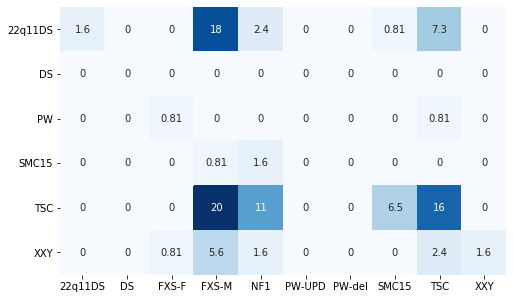

In [75]:
fig, ax = plt.subplots(figsize=(8,16))
sns.heatmap((rfc_weighted_resdict['res_df']), cmap='Blues', annot = (rfc_weighted_resdict['res_df'])/1.24, 
            square=True, cbar=False, ax=ax);

B_labels = np.unique(y_syn_B);
B_labels[1] = 'DS';

Rev_labels = np.unique(y_syn_all);
Rev_labels[1] = 'DS';

ax.set_xticklabels(Rev_labels);
ax.set_yticklabels(B_labels);